In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.utils import plot_model

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
!nvidia-smi

Thu Apr 22 17:04:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla M60           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   61C    P0   102W / 150W |   4794MiB /  7618MiB |     99%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
  except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
    print(e)

In [5]:
base_dir = './pre'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(
        rescale=1/255,    
#        rotation_range=40,
#        width_shift_range=0.1,
#        height_shift_range=0.1,
#        zoom_range=0.2,
#        horizontal_flip=True,
#        vertical_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
     rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
#     color_mode='grayscale',
    target_size=(150,150),
    batch_size=100,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
#     color_mode='grayscale',
    target_size=(150,150),
    batch_size=100,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    validation_dir,
#     color_mode='grayscale',
    target_size=(150,150),
    batch_size=100,
    class_mode='categorical'
)

Found 15986 images belonging to 7 classes.
Found 3992 images belonging to 7 classes.
Found 2074 images belonging to 7 classes.


# 전이 학습

In [6]:
# pretrained network
model_base = InceptionResNetV2(include_top=False, 
                            weights='imagenet', input_shape=(150,150,3))
# model_base의 weight학습을 동결
model_base.trainable=False

model_base.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
________________________________________________________________________________

__________________________________________________________________________________________________
batch_normalization_144 (BatchN (None, 7, 7, 192)    576         conv2d_144[0][0]                 
__________________________________________________________________________________________________
batch_normalization_147 (BatchN (None, 7, 7, 192)    576         conv2d_147[0][0]                 
__________________________________________________________________________________________________
activation_144 (Activation)     (None, 7, 7, 192)    0           batch_normalization_144[0][0]    
__________________________________________________________________________________________________
activation_147 (Activation)     (None, 7, 7, 192)    0           batch_normalization_147[0][0]    
__________________________________________________________________________________________________
block17_18_mixed (Concatenate)  (None, 7, 7, 384)    0           activation_144[0][0]             
          

In [7]:
model = Sequential()

# pretrained network를 우리의 모델 앞에 추가
model.add(model_base)

model.add(Flatten())

model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

model.summary()

model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 3, 3, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 13824)             0         
_________________________________________________________________
dropout (Dropout)            (None, 13824)             0         
_________________________________________________________________
dense (Dense)                (None, 7)                 96775     
Total params: 54,433,511
Trainable params: 96,775
Non-trainable params: 54,336,736
_________________________________________________________________


# Fine Tuning

In [8]:
model_base.trainable=True

# 상위 layer 동결해제
for layer in model_base.layers:
    if layer.name in ['conv_7b', 'block8_10_conv']:
        layer.trainable=True
    else:
        layer.trainable=False

# learning_rate 더 작게 설정
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy',
              metrics=['accuracy'])

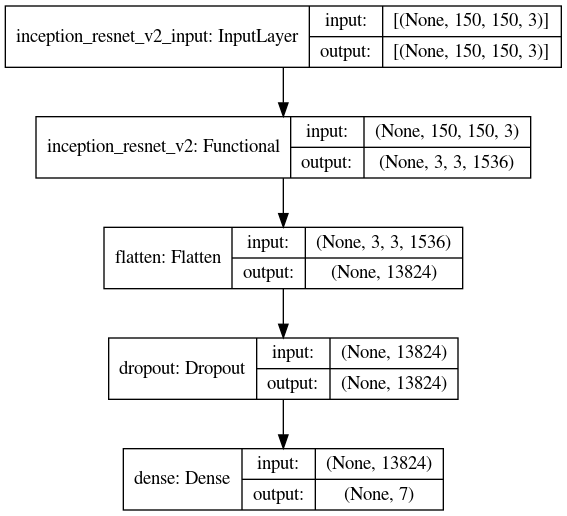

In [9]:
plot_model(model, show_shapes=True, rankdir='TB', dpi=96, 
           to_file='./models/InceptionResNetV2_1/InceptionResNetV2_1-2.png')

In [10]:
history = model.fit(train_generator, steps_per_epoch=159, epochs=20,
                    validation_data=validation_generator, validation_steps=39)

Epoch 1/20
159/159 [==============================] - 219s 1s/step - loss: 2.9271 - accuracy: 0.2282 - val_loss: 1.7833 - val_accuracy: 0.3862
Epoch 2/20
159/159 [==============================] - 193s 1s/step - loss: 2.3671 - accuracy: 0.3011 - val_loss: 1.6817 - val_accuracy: 0.4074
Epoch 3/20
159/159 [==============================] - 186s 1s/step - loss: 2.1202 - accuracy: 0.3433 - val_loss: 1.6149 - val_accuracy: 0.4338
Epoch 4/20
159/159 [==============================] - 137s 862ms/step - loss: 1.9725 - accuracy: 0.3617 - val_loss: 1.5789 - val_accuracy: 0.4338
Epoch 5/20
159/159 [==============================] - 136s 855ms/step - loss: 1.8680 - accuracy: 0.3882 - val_loss: 1.5575 - val_accuracy: 0.4408
Epoch 6/20
159/159 [==============================] - 136s 858ms/step - loss: 1.7257 - accuracy: 0.4071 - val_loss: 1.5268 - val_accuracy: 0.4513
Epoch 7/20
159/159 [==============================] - 157s 988ms/step - loss: 1.6665 - accuracy: 0.4283 - val_loss: 1.5074 - val_accu

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


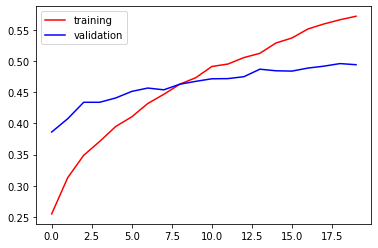

In [11]:
# history 객체 확인
print(history.history.keys())

train_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

train_loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.plot(train_acc, color='r', label='training')
plt.plot(validation_acc, color='b', label='validation')
plt.legend()
plt.savefig('./models/InceptionResNetV2_1/InceptionResNetV2_1-2_acc.jpg')
plt.show()

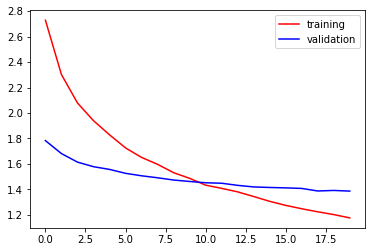

In [12]:
plt.plot(train_loss, color='r', label='training')
plt.plot(validation_loss, color='b', label='validation')
plt.legend()
plt.savefig('./models/InceptionResNetV2_1/InceptionResNetV2_1-2_val.jpg')
plt.show()

In [13]:
result = model.evaluate(test_generator)
print(np.round(result, 4))

21/21 [==============================] - 15s 709ms/step - loss: 1.3436 - accuracy: 0.5034
[1.3436 0.5034]


In [14]:
model.save('./models/InceptionResNetV2_1/InceptionResNetV2_1-2.h5')